# Obenter matriz de adyacencia

In [1]:
import osmnx as ox
import networkx as nx 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
point = (-0.206412, -78.499363)

[ 0  0 29 21 21 13 14 12 12  4  3 26 26 26  3  3  3 32  2  2 31  9 24 24
 24 16 16 16 14 28  2 31 14 34 28 17 34 17 20  6 17 14 10 15 15 18 33 30
 23 23 11 11 11 26 13  7 22  5  5 25  6 18 29 11 15  5  5 24  3 20 24  9
 24 24 24 24 24 24  3 25 27  1  9  0 16 16 16  2  7  7 33 33 33  8  8  8
  8  8  8  0  0  8  8  8  8 27 15  0  4  4 28 28 19  3  3 20 25 25  1  1
  6  6  7 23 22 22  2 10  6  6  6]


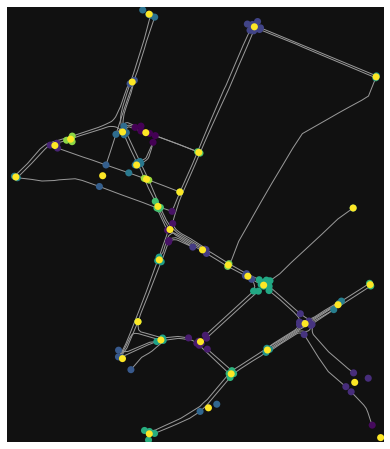

In [3]:
num_clusters = int(35)
point = (-0.206412, -78.499363)
filtro = '["highway"~"primary|secondary|tertiary"]'
graph = ox.graph_from_point(point, dist=1000, simplify=True, custom_filter=filtro)
g_nodes = list(graph.nodes)
positions = {}
for node_name in g_nodes:
    positions[node_name] = (graph.nodes[node_name]['x'],graph.nodes[node_name]['y'])
positions_x = nx.get_node_attributes(graph,'x')
positions_y = nx.get_node_attributes(graph,'y')
positions_for_data={'nodos':g_nodes,
    'position_x':positions_x.values(),
    'position_y':positions_y.values()}
data = pd.DataFrame.from_dict(positions_for_data)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['position_x','position_y']])
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
colors_num = cluster.fit_predict(data_scaled)
print(colors_num)
labeldict = {}
for i,node_name in enumerate(g_nodes):
    labeldict[node_name] = colors_num[i]

data['cluster']=colors_num

centros = []
for cluster in range(max(colors_num)+1):
    indices = np.where(data['cluster']==cluster)
    grupo = data.iloc[indices]
    centro_x = grupo['position_x'].mean()
    centro_y = grupo['position_y'].mean()

    centros.append((centro_x,centro_y))        

inicio_nodos = 0
idx = inicio_nodos
colores_centros = []
for centro in centros:
    graph.add_node(idx)
    graph.nodes[idx]['x']=centro[0]
    graph.nodes[idx]['y']=centro[1]
    colores_centros.append(40)
    idx+=1

colors_num_2 = np.append(colors_num,colores_centros)

#remover edges dentro del mismo grupo
edges = list(graph.edges())

#formar la matriz de adyacencia si son de grupos distintos
adj_matrix = np.zeros((num_clusters,num_clusters))

for nodo1,nodo2 in edges:
    cluster1 = int(data['cluster'][np.where(data['nodos']==nodo1)[0]])
    cluster2 = int(data['cluster'][np.where(data['nodos']==nodo2)[0]])
    if (cluster1 == cluster2):
        #se quitan las calles del mismo grupo
        graph.remove_edge(nodo1,nodo2)
    else:
        adj_matrix[cluster1][cluster2] = 1    
        #si es doble vía
        if (not graph.edges[(nodo1,nodo2,0)]['oneway']):
            adj_matrix[cluster2][cluster1] = 1        

fig, ax = ox.plot_graph(graph,
    node_color=colors_num_2,    
    node_size=50)


In [4]:
data

,nodos,position_x,position_y,cluster
0,264268562,-78.500598,-0.202221,0
1,264268564,-78.500014,-0.202610,0
2,264268569,-78.498284,-0.203269,29
3,264270346,-78.490999,-0.200246,21
4,264270354,-78.490973,-0.200167,21
...,...,...,...,...
126,5183570478,-78.499472,-0.206960,2
127,6325538189,-78.501044,-0.200487,10
128,7009132784,-78.493927,-0.210743,6
129,7009133900,-78.493726,-0.210191,6


In [9]:
max(data['cluster'])

34

In [6]:
adj_matrix = np.zeros((35,35))

In [13]:
edges = list(graph.edges())

In [14]:
edges[:10]

[(264268564, 264268569),
 (264268569, 267939607),
 (264268569, 264268564),
 (264270346, 267939758),
 (264270354, 3726280025),
 (267036924, 267960698),
 (267036924, 3726294618),
 (267036926, 4207542605),
 (267036926, 267036924),
 (267036927, 267939876)]

In [16]:
graph.edges[(264268564, 264268569, 0)]

{'osmid': [356064688, 107938398],
 'oneway': False,
 'name': 'San Gregorio',
 'highway': 'tertiary',
 'length': 205.81,
 'geometry': <shapely.geometry.linestring.LineString at 0x1c8ae03fc10>}

Oneway significa que va en una sola dirección.

In [24]:
for nodo1,nodo2 in edges:
    cluster1 = int(data['cluster'][np.where(data['nodos']==nodo1)[0]])
    cluster2 = int(data['cluster'][np.where(data['nodos']==nodo2)[0]])
    adj_matrix[cluster1][cluster2] = 1    
    #si es doble vía
    if (not graph.edges[(nodo1,nodo2,0)]['oneway']):
        adj_matrix[cluster2][cluster1] = 1 
        

In [25]:
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

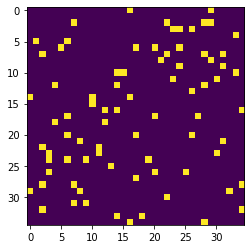

In [6]:
plt.imshow(adj_matrix)

In [28]:
np.where(adj_matrix[0]==1)

(array([16, 29], dtype=int64),)

In [29]:
np.where(adj_matrix[16]==1)

(array([12, 14, 34], dtype=int64),)

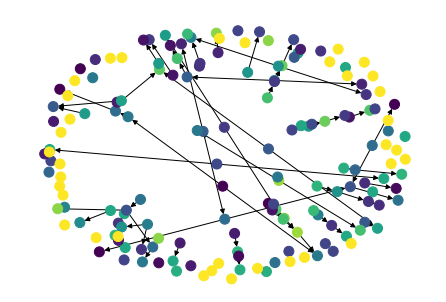

In [11]:
positions = {}
g_nodes = list(graph.nodes())
for node_name in g_nodes:
    positions[node_name] = (graph.nodes[node_name]['x'],graph.nodes[node_name]['y'])
nx.draw(graph,node_size=100,node_color=colors_num_2)

In [12]:
G = nx.DiGraph(adj_matrix)

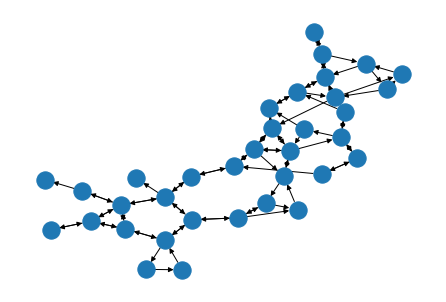

In [18]:
pos = nx.circular_layout(G)
nx.draw_kamada_kawai(G)

In [7]:
centros

[(-78.50040125, -0.20248826666666667),
 (-78.49079993333334, -0.21495733333333333),
 (-78.49941296, -0.20644891999999998),
 (-78.4981667125, -0.21103442500000003),
 (-78.50411983333333, -0.20301313333333335),
 (-78.491860325, -0.2126993),
 (-78.49388817142858, -0.21029951428571433),
 (-78.498081775, -0.20728062500000002),
 (-78.49596283, -0.19816061999999998),
 (-78.49622876666668, -0.2083583),
 (-78.50095725, -0.20041799999999999),
 (-78.5013562, -0.211726575),
 (-78.5021648, -0.2042497),
 (-78.4978411, -0.21373910000000002),
 (-78.5013519, -0.20246205),
 (-78.50026352500001, -0.197645025),
 (-78.5007766, -0.20381238333333332),
 (-78.49254119999999, -0.20952433333333334),
 (-78.50571395, -0.20430165),
 (-78.4919239, -0.20557),
 (-78.49542793333333, -0.21137536666666668),
 (-78.49098605, -0.20020670000000002),
 (-78.49984930000001, -0.20768993333333333),
 (-78.49978503333334, -0.21096573333333335),
 (-78.49558266363637, -0.20872455454545458),
 (-78.500259975, -0.214803425),
 (-78.49691

In [10]:
data_centers = pd.DataFrame(adj_matrix)

In [13]:
data_centers['cluster_point'] = centros

In [14]:
data_centers

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,cluster_point
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.50040125, -0.20248826666666667)"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.49079993333334, -0.21495733333333333)"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.49941296, -0.20644891999999998)"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.4981667125, -0.21103442500000003)"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(-78.50411983333333, -0.20301313333333335)"
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.491860325, -0.2126993)"
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.49388817142858, -0.21029951428571433)"
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"(-78.498081775, -0.20728062500000002)"
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.49596283, -0.19816061999999998)"
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(-78.49622876666668, -0.2083583)"


In [15]:
data_centers.to_csv(r'centros_googleApi')